In [171]:
import psycopg2 as psql
import sqlalchemy as alc
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from decouple import AutoConfig
from pathlib import Path
from importlib import reload

In [2]:
config = AutoConfig(Path('./.env'))

In [3]:
# Working on integrating Pg with Python for a more streamlined process
engine = alc.create_engine(
    f"postgresql+psycopg2://{config('DB_USER')}:{config('DB_PASS')}@{config('DB_HOST')}/{config('DB_NAME')}", 
)

In [129]:
data = pd.read_sql_table('hour', engine)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  object        
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  bool          
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  bool          
 9   weathersit  17379 non-null  object        
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

## Surface Analysis

### Correlation Map

In [130]:
corr = data.corr()
corr

instant    dteday    season        yr      mnth        hr   
instant     1.000000  0.999995  0.404046  0.866014  0.489164 -0.004775  \
dteday      0.999995  1.000000  0.404452  0.865648  0.489808 -0.006161   
season      0.404046  0.404452  1.000000 -0.010742  0.830386 -0.006117   
yr          0.866014  0.865648 -0.010742  1.000000 -0.010473 -0.003867   
mnth        0.489164  0.489808  0.830386 -0.010473  1.000000 -0.005772   
hr         -0.004775 -0.006161 -0.006117 -0.003867 -0.005772  1.000000   
holiday     0.014723  0.014737 -0.009585  0.006692  0.018430  0.000479   
weekday     0.001357  0.001372 -0.002335 -0.004485  0.010400 -0.003498   
workingday -0.003416 -0.003366  0.013743 -0.002196 -0.003477  0.002285   
weathersit -0.014198 -0.014063 -0.014524 -0.019157  0.005400 -0.020203   
temp        0.136178  0.136074  0.312025  0.040913  0.201691  0.137603   
atemp       0.137615  0.137543  0.319380  0.039222  0.208096  0.133750   
hum         0.009577  0.010196  0.150625 -0.083546  0.164411 -0.276498   
windspeed  -0.074505 -0.074645 -0.149773 -0.008740 -0.135386  0.137252   
casual      0.158295  0.157821  0.120206  0.142779  0.068457  0.301202   
registered  0.282046  0.281450  0.174226  0.253684  0.122273  0.374141   
cnt         0.278379  0.277753  0.178056  0.250495  0.120638  0.394071   

             holiday   weekday  workingday  weathersit      temp     atemp   
instant     0.014723  0.001357   -0.003416   -0.014198  0.136178  0.137615  \
dteday      0.014737  0.001372   -0.003366   -0.014063  0.136074  0.137543   
season     -0.009585 -0.002335    0.013743   -0.014524  0.312025  0.319380   
yr          0.006692 -0.004485   -0.002196   -0.019157  0.040913  0.039222   
mnth        0.018430  0.010400   -0.003477    0.005400  0.201691  0.208096   
hr          0.000479 -0.003498    0.002285   -0.020203  0.137603  0.133750   
holiday     1.000000 -0.102088   -0.252471   -0.017036 -0.027340 -0.030973   
weekday    -0.102088  1.000000    0.035955    0.003311 -0.001795 -0.008821   
workingday -0.252471  0.035955    1.000000    0.044672  0.055390  0.054667   
weathersit -0.017036  0.003311    0.044672    1.000000 -0.102640 -0.105563   
temp       -0.027340 -0.001795    0.055390   -0.102640  1.000000  0.987672   
atemp      -0.030973 -0.008821    0.054667   -0.105563  0.987672  1.000000   
hum        -0.010588 -0.037158    0.015688    0.418130 -0.069881 -0.051918   
windspeed   0.003988  0.011502   -0.011830    0.026226 -0.023125 -0.062336   
casual      0.031564  0.032721   -0.300942   -0.152628  0.459616  0.454080   
registered -0.047345  0.021578    0.134326   -0.120966  0.335361  0.332559   
cnt        -0.030927  0.026900    0.030284   -0.142426  0.404772  0.400929   

                 hum  windspeed    casual  registered       cnt  
instant     0.009577  -0.074505  0.158295    0.282046  0.278379  
dteday      0.010196  -0.074645  0.157821    0.281450  0.277753  
season      0.150625  -0.149773  0.120206    0.174226  0.178056  
yr         -0.083546  -0.008740  0.142779    0.253684  0.250495  
mnth        0.164411  -0.135386  0.068457    0.122273  0.120638  
hr         -0.276498   0.137252  0.301202    0.374141  0.394071  
holiday    -0.010588   0.003988  0.031564   -0.047345 -0.030927  
weekday    -0.037158   0.011502  0.032721    0.021578  0.026900  
workingday  0.015688  -0.011830 -0.300942    0.134326  0.030284  
weathersit  0.418130   0.026226 -0.152628   -0.120966 -0.142426  
temp       -0.069881  -0.023125  0.459616    0.335361  0.404772  
atemp      -0.051918  -0.062336  0.454080    0.332559  0.400929  
hum         1.000000  -0.290105 -0.347028   -0.273933 -0.322911  
windspeed  -0.290105   1.000000  0.090287    0.082321  0.093234  
casual     -0.347028   0.090287  1.000000    0.506618  0.694564  
registered -0.273933   0.082321  0.506618    1.000000  0.972151  
cnt        -0.322911   0.093234  0.694564    0.972151  1.000000

<AxesSubplot: >

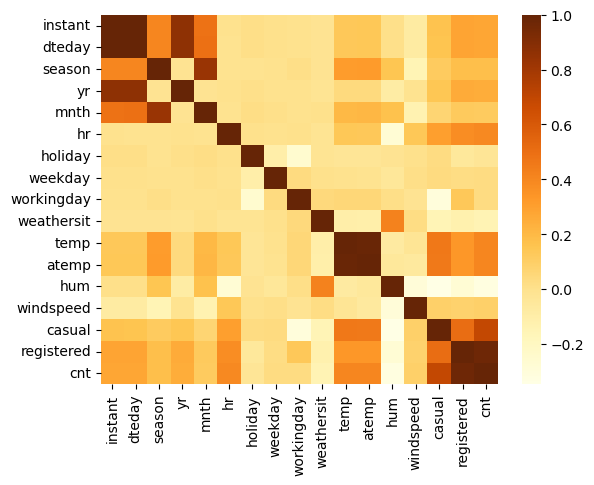

In [131]:
sns.heatmap(corr, cmap=sns.color_palette("YlOrBr", as_cmap=True))

In [132]:
cnt_corr = corr.loc['cnt', :].sort_values(ascending=False)
cnt_corr

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
dteday        0.277753
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

Looks like there exists some correlation between hour of the day and the amount of rentals. But according to rentals vs hr graph, there is correlation in behavior in users by time of day, meaning its best to group hours to remove noise: <em>morning (1), afternoon (2), evening (3), night (4)</em>.

In [133]:
st = "SELECT *, "\
            "CASE WHEN hr < 6 THEN 4 " \
                 "WHEN hr < 12 THEN 1 " \
                 "WHEN hr < 18 THEN 2 " \
                 "ELSE 3 END day_period " \
            "FROM hour;"

In [134]:
time_pd = pd.read_sql(st, engine)

In [135]:
time_pd.head()

instant      dteday season  yr  mnth  hr  holiday  weekday  workingday   
0        1  2011-01-01      1   0     1   0    False        6       False  \
1        2  2011-01-01      1   0     1   1    False        6       False   
2        3  2011-01-01      1   0     1   2    False        6       False   
3        4  2011-01-01      1   0     1   3    False        6       False   
4        5  2011-01-01      1   0     1   4    False        6       False   

  weathersit  temp   atemp   hum  windspeed  casual  registered  cnt   
0          1  0.24  0.2879  0.81        0.0       3          13   16  \
1          1  0.22  0.2727  0.80        0.0       8          32   40   
2          1  0.22  0.2727  0.80        0.0       5          27   32   
3          1  0.24  0.2879  0.75        0.0       3          10   13   
4          1  0.24  0.2879  0.75        0.0       0           1    1   

   day_period  
0           4  
1           4  
2           4  
3           4  
4           4

### Categorical Features -> Dummy Vars
Correlation values are ambiguous given that some features are categorical. Breaking up into dummy variables.

In [136]:
cat_features = ['season', 'weathersit', 'weekday', 'day_period']

In [187]:
dummy = pd.get_dummies(time_pd, columns=cat_features)
dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   instant       17379 non-null  int64  
 1   dteday        17379 non-null  object 
 2   yr            17379 non-null  int64  
 3   mnth          17379 non-null  int64  
 4   hr            17379 non-null  int64  
 5   holiday       17379 non-null  bool   
 6   workingday    17379 non-null  bool   
 7   temp          17379 non-null  float64
 8   atemp         17379 non-null  float64
 9   hum           17379 non-null  float64
 10  windspeed     17379 non-null  float64
 11  casual        17379 non-null  int64  
 12  registered    17379 non-null  int64  
 13  cnt           17379 non-null  int64  
 14  season_1      17379 non-null  bool   
 15  season_2      17379 non-null  bool   
 16  season_3      17379 non-null  bool   
 17  season_4      17379 non-null  bool   
 18  weathersit_1  17379 non-nu

In [138]:
dummy.head()

instant      dteday  yr  mnth  hr  holiday  workingday  temp   atemp   hum   
0        1  2011-01-01   0     1   0    False       False  0.24  0.2879  0.81  \
1        2  2011-01-01   0     1   1    False       False  0.22  0.2727  0.80   
2        3  2011-01-01   0     1   2    False       False  0.22  0.2727  0.80   
3        4  2011-01-01   0     1   3    False       False  0.24  0.2879  0.75   
4        5  2011-01-01   0     1   4    False       False  0.24  0.2879  0.75   

   ...  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  weekday_6   
0  ...      False      False      False      False      False       True  \
1  ...      False      False      False      False      False       True   
2  ...      False      False      False      False      False       True   
3  ...      False      False      False      False      False       True   
4  ...      False      False      False      False      False       True   

   day_period_1  day_period_2  day_period_3  day_period_4  
0         False         False         False          True  
1         False         False         False          True  
2         False         False         False          True  
3         False         False         False          True  
4         False         False         False          True  

[5 rows x 33 columns]

## Methods

<ul>
    <li>Will use k-fold cross validation to train/test the models. Will use $k=10$ for no other reason than it's the most common choice of k. Reason for k-fold CV is because I want to minimize variance in the model.</li>
    <li>Will be using RMSE since the rentals seem to follow a general year-to-year pattern (at least as observed in years 2011, 2012) and any deviation from that is very unlikely and undesirable.</li>
</ul>

Removing features correlated with above created ones and *registered, casual* because they will only skew predictions. Also removing *yr* as it holds no relevance to data outside those 2 years.

In [208]:
# Ignore features correlated with the 'cnt' column being predicted
not_interest = {'yr', 'casual', 'registered', 'dteday', 'mnth', 'hr', 'instant', 'cnt'}
features = set(dummy.columns).difference(not_interest)
features = sorted(features)
features

['atemp',
 'day_period_1',
 'day_period_2',
 'day_period_3',
 'day_period_4',
 'holiday',
 'hum',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'temp',
 'weathersit_1',
 'weathersit_2',
 'weathersit_3',
 'weathersit_4',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'windspeed',
 'workingday']

## Linear Regression

Will first test the predictions of a basic linear regression model.

In [243]:
seed = 1000
rng = np.random.default_rng(seed)
rand = rng.permutation(dummy.shape[0])

In [244]:
k = 10
folds = [set(f) for f in np.array_split(rand, k)]
preds = dict()

In [245]:
for i, test_idx in enumerate(folds):
    # Get the k-1 training folds
    train_idx = list(set(data_pred.index).difference(test_idx))
    train = dummy.iloc[train_idx, :]
    test_idx = list(test_idx)
    test = dummy.iloc[test_idx, :]
    
    mod = LinearRegression()
    mod.fit(train[features], 
            train['cnt'])
    
    pred = dict(zip(test_idx, mod.predict(test[features])))
    preds.update(pred)
    
preds = pd.Series(preds).rename('lin_predict')

In [246]:
data_pred = pd.concat([data, preds], axis=1).sort_values('cnt')

In [247]:
lin_rmses = mean_squared_error(data_pred.loc[:, 'cnt'], data_pred.loc[:, 'lin_predict'], squared=False)
lin_rmses

135.21536845745723

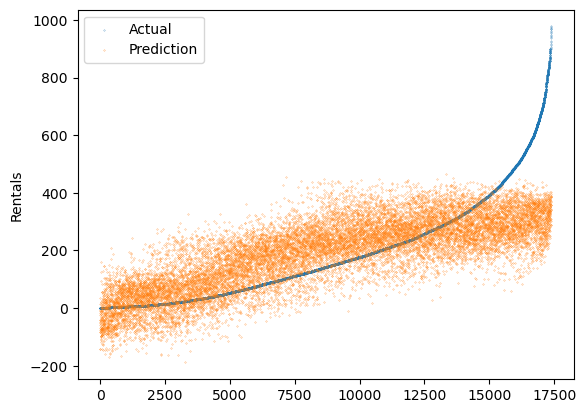

In [248]:
plt.scatter(range(data_pred.shape[0]), data_pred['cnt'], s=0.04, label='Actual')
plt.scatter(range(data_pred.shape[0]), data_pred['lin_predict'], s=0.04, label='Prediction')
plt.ylabel('Rentals')
plt.legend()
plt.show()

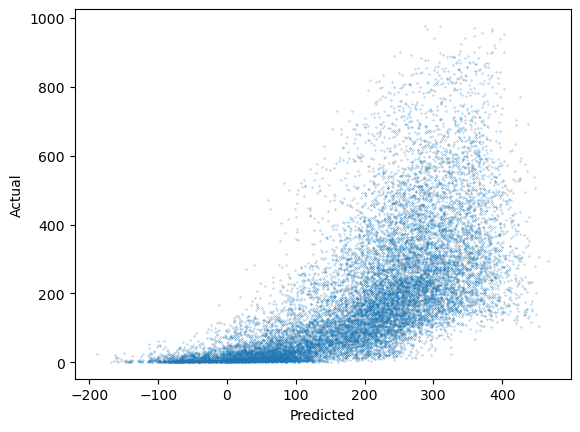

In [249]:
plt.scatter(data_pred['lin_predict'], data_pred['cnt'], s=0.04)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### NOTE:

As assumed, the linear regression model underfits the data, and perhaps isn't the best predictive model to begin with due to the exponential distribution of the rental data.

## Decision Trees:

In [250]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [251]:
k = 10
folds = [set(f) for f in np.array_split(rand, k)]
preds = dict()

In [252]:
for i, test_idx in enumerate(folds):
    # Get the k-1 training folds
    train_idx = list(set(dummy.index).difference(test_idx))
    train = dummy.iloc[train_idx, :]
    test_idx = list(test_idx)
    test = dummy.iloc[test_idx, :]
    
    mod = DecisionTreeRegressor(random_state=i, max_depth=6)
    mod.fit(train[features], 
            train['cnt'])
    
    pred = dict(zip(test_idx, mod.predict(test[features])))
    preds.update(pred)
    
preds = pd.Series(preds).rename('tree_predict')

In [253]:
tree_pred = pd.concat([data_pred, preds], axis=1)
tree_pred.head()

instant     dteday season  yr  mnth  hr  holiday  weekday  workingday   
10896    10897 2012-04-04      2   1     4   4    False        3        True  \
8052      8053 2011-12-07      4   0    12   4    False        3        True   
10201    10202 2012-03-06      1   1     3   3    False        2        True   
210        211 2011-01-10      1   0     1   1    False        1        True   
212        213 2011-01-10      1   0     1   3    False        1        True   

      weathersit  temp   atemp   hum  windspeed  casual  registered  cnt   
10896          1  0.42  0.4242  0.67     0.0896       0           1    1  \
8052           3  0.46  0.4545  1.00     0.1642       0           1    1   
10201          1  0.18  0.1667  0.51     0.2836       0           1    1   
210            1  0.12  0.1212  0.50     0.2836       1           0    1   
212            1  0.12  0.1212  0.50     0.2239       0           1    1   

       lin_predict  tree_predict  
10896     33.75000      9.583012  
8052     -10.50000     11.855263  
10201    -57.53125      4.955056  
210      -68.50000      4.378378  
212      -75.50000      6.353896

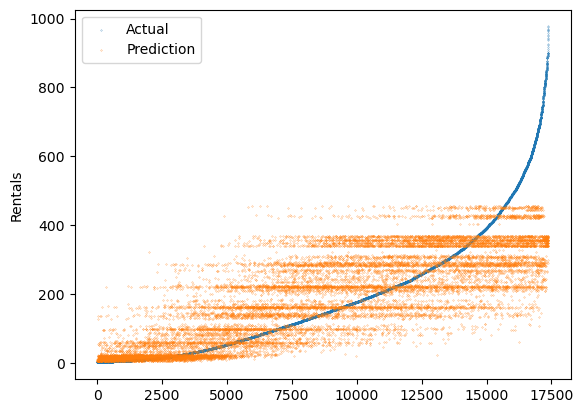

In [256]:
plt.scatter(range(tree_pred.shape[0]), tree_pred['cnt'], s=0.04, label='Actual')
plt.scatter(range(tree_pred.shape[0]), tree_pred['tree_predict'], s=0.04, label='Prediction')
plt.ylabel('Rentals')
plt.legend()
plt.show()

In [257]:
tree_rmses = mean_squared_error(tree_pred.loc[:, 'cnt'], tree_pred.loc[:, 'tree_predict'], squared=False)
tree_rmses

128.89031266450252

## Random Forests

In [258]:
from sklearn.ensemble import RandomForestRegressor

In [259]:
k = 10
folds = [set(f) for f in np.array_split(rand, k)]
preds = dict()

In [260]:
for i, test_idx in enumerate(folds):
    # Get the k-1 training folds
    train_idx = list(set(dummy.index).difference(test_idx))
    train = dummy.iloc[train_idx, :]
    test_idx = list(test_idx)
    test = dummy.iloc[test_idx, :]
    
    mod = RandomForestRegressor(random_state=i, max_depth=6)
    mod.fit(train[features], 
            train['cnt'])
    
    pred = dict(zip(test_idx, mod.predict(test[features])))
    preds.update(pred)
    
preds = pd.Series(preds).rename('rf_predict')

In [261]:
rf_pred = pd.concat([tree_pred, preds], axis=1)
rf_pred.head()

instant     dteday season  yr  mnth  hr  holiday  weekday  workingday   
10896    10897 2012-04-04      2   1     4   4    False        3        True  \
8052      8053 2011-12-07      4   0    12   4    False        3        True   
10201    10202 2012-03-06      1   1     3   3    False        2        True   
210        211 2011-01-10      1   0     1   1    False        1        True   
212        213 2011-01-10      1   0     1   3    False        1        True   

      weathersit  temp   atemp   hum  windspeed  casual  registered  cnt   
10896          1  0.42  0.4242  0.67     0.0896       0           1    1  \
8052           3  0.46  0.4545  1.00     0.1642       0           1    1   
10201          1  0.18  0.1667  0.51     0.2836       0           1    1   
210            1  0.12  0.1212  0.50     0.2836       1           0    1   
212            1  0.12  0.1212  0.50     0.2239       0           1    1   

       lin_predict  tree_predict  rf_predict  
10896     33.75000      9.583012   13.344868  
8052     -10.50000     11.855263   10.415953  
10201    -57.53125      4.955056    5.118523  
210      -68.50000      4.378378    5.072120  
212      -75.50000      6.353896    5.886569

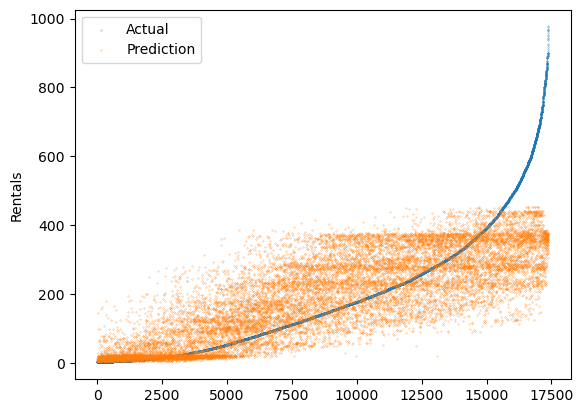

In [262]:
plt.scatter(range(rf_pred.shape[0]), rf_pred['cnt'], s=0.04, label='Actual')
plt.scatter(range(rf_pred.shape[0]), rf_pred['rf_predict'], s=0.04, label='Prediction')
plt.ylabel('Rentals')
plt.legend()
plt.show()

In [263]:
rf_rmses = mean_squared_error(rf_pred.loc[:, 'cnt'], rf_pred.loc[:, 'rf_predict'], squared=False)
rf_rmses

125.91380779751022